<h1>Long term nutrient data analysis</h1>
<strong>Hypothesis</strong> = in the recent decades there is a trend in increasing (complete?) depletion of Nitrate in the intermediate waters, where the levels should theoretically be quite high thanks to the mixing & lack of Primary Production. 

In [1]:
#IMPORTS

import numpy as np
import pandas as pd
from scipy import interpolate
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore')
sns.set_theme()

<h2>Loading the data</h2>

In [2]:
path = "Data"

files = os.listdir(path)
"""
for index, file in enumerate(files):
    os.rename(os.path.join(path, file), os.path.join(path, file[:len(file)-3] +'.txt'))
"""

"\nfor index, file in enumerate(files):\n    os.rename(os.path.join(path, file), os.path.join(path, file[:len(file)-3] +'.txt'))\n"

In [3]:
def rem_last_two(s):
    return s[:len(s)-1]
def string_to_list(s):
    return s.split(" ")

list_of_dfs = []

print("All data files available:")

for i, filename in enumerate(os.listdir(path)):
    if filename.endswith(".txt"):  #going from text file to pandas DataFrame
        with open(os.path.join(path,filename)) as f:
            lines = f.readlines()
            lines = list(map(rem_last_two, lines))
            lines = list(map(string_to_list, lines)) 
            lines = [[i for i in k if i!=""] for k in lines] #getting rid of the "" in the data file (.txt)
            lines = [[float(x) for x in i] for i in lines]

        var = filename[:3]
        df = pd.DataFrame(lines)
        df.columns = ["Year", "Month", "Day", "Hour","Minute", "Second", "Depth", var]
        df.drop(["Hour","Minute","Second"], axis=1, inplace=True)
        list_of_dfs.append(df)
        print(F"{i} filename: {filename}, datapoints: {len(list_of_dfs[i])}")
    else:
        pass
    
#113 - Akona Basin
#213 - Bornholm Basin
#271 - Eastern Gotland Basin

All data files available:
0 filename: nh4_213.txt, datapoints: 6073
1 filename: nh4_271_vers_2019.txt, datapoints: 9223
2 filename: no3_113_vers_2019.txt, datapoints: 3834
3 filename: no3_213_vers_2019.txt, datapoints: 8524
4 filename: no3_271_vers_2019.txt, datapoints: 11335
5 filename: oxy_113_vers_2019.txt, datapoints: 12189
6 filename: oxy_213_vers_2019.txt, datapoints: 39522
7 filename: oxy_271_vers_2019_01.txt, datapoints: 29184
8 filename: po4_113_vers_2019.txt, datapoints: 3866
9 filename: po4_213_vers_2019.txt, datapoints: 9047
10 filename: po4_271_vers_2019.txt, datapoints: 12076
11 filename: sal_113_vers_2015.txt, datapoints: 23025
12 filename: sal_213_vers_2015_02.txt, datapoints: 49131
13 filename: sal_271_vers_2019_01.txt, datapoints: 129041
14 filename: temp_113_vers_2015.txt, datapoints: 23478
15 filename: temp_213_vers_2015_02.txt, datapoints: 45309
16 filename: temp_271_vers_2019.txt, datapoints: 127446


<strong>Finding:</strong> There is a lot of datapints for T and Salinity but less for the nutrients 

In [5]:
month_dict = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
    }

units_dict = {
    "no3":"[mmol NO3/m**3]",
    "sal":"[g/kg]",
    }

title_dict = {
    "no3":"NO3",
    "sal":"Salinity"
}

In [6]:
list_of_dfs[7].head()

Year  Month   Day  Depth   oxy
0  1902.0   11.0  16.0   20.0  8.16
1  1902.0   11.0  16.0   50.0  7.89
2  1902.0   11.0  16.0  100.0  3.39
3  1902.0   11.0  16.0  140.0  2.67
4  1902.0   11.0  16.0  210.0  3.20

In [7]:
#transforming the LIST OF dataframes into a DICTIONARY of dataframes
dict_of_dfs = {
    "no3":{
        "113":list_of_dfs[2],
        "213":list_of_dfs[3],
        "271":list_of_dfs[4],
    },
    "sal":{
        "113":list_of_dfs[11],
        "213":list_of_dfs[12],
        "271":list_of_dfs[13],
    }
}

In [8]:
def get_df_monthly_means(df):
    df["Depth"] = df["Depth"].round(0) #round all Depths
    df=df.groupby(["Year","Depth","Month"]).mean() #return mean variable (and day) for each year+month+depth 
    return df.reset_index()

get_df_monthly_means(dict_of_dfs["no3"]["113"])

Year  Depth  Month   Day    no3
0     1969.0    0.0    5.0  14.0  0.100
1     1969.0    0.0    8.0   2.0  0.320
2     1969.0    0.0   11.0  29.0  1.550
3     1969.0    2.0   12.0  16.0  1.620
4     1969.0    5.0    5.0  14.0  0.100
...      ...    ...    ...   ...    ...
2902  2019.0   46.0    1.0  31.0  5.745
2903  2019.0   46.0    3.0  16.0  7.415
2904  2019.0   46.0    5.0   7.0  0.000
2905  2019.0   46.0    7.0  30.0  1.985
2906  2019.0   46.0   10.0  13.0  4.940

[2907 rows x 5 columns]

<h2>Exploration of the data</h2>

In [9]:
#THE PARAMETERS OF INTEREST
"""
shallow_range = range(0,25)
deep_range = range(25,60)
#months = range(5,6)
months = [3,5]
"""

'\nshallow_range = range(0,25)\ndeep_range = range(25,60)\n#months = range(5,6)\nmonths = [3,5]\n'

Data divided into two discrete categories, i.e., shallow and deep - not very relevant and useful

In [7]:
#Data coverage of NO3-
"""
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,8))

rows = ["113","213","271"]
cols = [F"surface water - {shallow_range}",F"deep water - {deep_range}"]

for i, df in enumerate(list_of_dfs[2:5]): #list_of_dfs stores the dataframes of all the data
    axes[i,0].set_xlim(1970,2010)
    axes[i,0].set_ylim(0,40)
    axes[i,1].set_xlim(1970,2010)
    axes[i,1].set_ylim(0,40)
    sns.histplot(data=df[(df["Month"].isin(months)) & (df["Depth"].isin(shallow_range))], x = "Year",  multiple="stack", hue="Month", ax = axes[i,0], binwidth=1)
    sns.histplot(data=df[(df["Month"].isin(months)) & (df["Depth"].isin(deep_range))], x = "Year", multiple="stack", hue="Month", ax = axes[i,1], binwidth=1)

pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

fig.suptitle(f'NO3 coverage for months: {", ".join(str(x) for x in list(months))}', fontsize=16, y=1.04, x=0.6)
fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

plt.show()
"""

'\nfig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,8))\n\nrows = ["113","213","271"]\ncols = [F"surface water - {shallow_range}",F"deep water - {deep_range}"]\n\nfor i, df in enumerate(list_of_dfs[2:5]): #list_of_dfs stores the dataframes of all the data\n    axes[i,0].set_xlim(1970,2010)\n    axes[i,0].set_ylim(0,40)\n    axes[i,1].set_xlim(1970,2010)\n    axes[i,1].set_ylim(0,40)\n    sns.histplot(data=df[(df["Month"].isin(months)) & (df["Depth"].isin(shallow_range))], x = "Year",  multiple="stack", hue="Month", ax = axes[i,0], binwidth=1)\n    sns.histplot(data=df[(df["Month"].isin(months)) & (df["Depth"].isin(deep_range))], x = "Year", multiple="stack", hue="Month", ax = axes[i,1], binwidth=1)\n\npad = 5 # in points\n\nfor ax, col in zip(axes[0], cols):\n    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),\n                xycoords=\'axes fraction\', textcoords=\'offset points\',\n                size=\'large\', ha=\'center\', va=\'baseline\')\n\nfor ax, row in zip(axes[:,0], 

In [8]:
#Data coverage of T
"""

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,6))

rows = ["113","213","271"]
cols = [F"surface water - {shallow_range}",F"deep water - {deep_range}"]

for i, df in enumerate(list_of_dfs[14:17]): #list_of_dfs stores the dataframes for all the data
    axes[i,0].set_xlim(1970,2010)
    axes[i,0].set_ylim(0,200)
    axes[i,1].set_xlim(1970,2010)
    axes[i,1].set_ylim(0,200)
    sns.histplot(data=df[(df["Month"].isin(months)) & (df["Depth"].isin(shallow_range))], x = "Year", ax = axes[i,0], binwidth=1)
    sns.histplot(data=df[(df["Month"].isin(months)) & (df["Depth"].isin(deep_range))], x = "Year", ax = axes[i,1], binwidth=1)

pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

fig.suptitle(f' T coverage for months: {" ".join(str(x) for x in list(months))}', fontsize=16, y=1.04, x=0.6)
fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

plt.show()
"""

'\n\nfig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,6))\n\nrows = ["113","213","271"]\ncols = [F"surface water - {shallow_range}",F"deep water - {deep_range}"]\n\nfor i, df in enumerate(list_of_dfs[14:17]): #list_of_dfs stores the dataframes for all the data\n    axes[i,0].set_xlim(1970,2010)\n    axes[i,0].set_ylim(0,200)\n    axes[i,1].set_xlim(1970,2010)\n    axes[i,1].set_ylim(0,200)\n    sns.histplot(data=df[(df["Month"].isin(months)) & (df["Depth"].isin(shallow_range))], x = "Year", ax = axes[i,0], binwidth=1)\n    sns.histplot(data=df[(df["Month"].isin(months)) & (df["Depth"].isin(deep_range))], x = "Year", ax = axes[i,1], binwidth=1)\n\npad = 5 # in points\n\nfor ax, col in zip(axes[0], cols):\n    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),\n                xycoords=\'axes fraction\', textcoords=\'offset points\',\n                size=\'large\', ha=\'center\', va=\'baseline\')\n\nfor ax, row in zip(axes[:,0], rows):\n    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.ya

In [9]:
#Data coverage of Salinity
"""

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,6))

rows = ["113","213","271"]
cols = [F"surface water - {shallow_range}",F"deep water - {deep_range}"]

for i, df in enumerate(list_of_dfs[11:14]): #list_of_dfs stores the dataframes for all the data
    axes[i,0].set_xlim(1970,2010)
    axes[i,0].set_ylim(0,200)
    axes[i,1].set_xlim(1970,2010)
    axes[i,1].set_ylim(0,200)
    sns.histplot(data=df[(df["Month"].isin(months)) & (df["Depth"].isin(shallow_range))], x = "Year", ax = axes[i,0], binwidth=1)
    sns.histplot(data=df[(df["Month"].isin(months)) & (df["Depth"].isin(deep_range))], x = "Year", ax = axes[i,1], binwidth=1)

pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

fig.suptitle(f'S coverage for months: {" ".join(str(x) for x in list(months))}', fontsize=16, y=1.04, x=0.6)
fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

plt.show()
"""

'\n\nfig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,6))\n\nrows = ["113","213","271"]\ncols = [F"surface water - {shallow_range}",F"deep water - {deep_range}"]\n\nfor i, df in enumerate(list_of_dfs[11:14]): #list_of_dfs stores the dataframes for all the data\n    axes[i,0].set_xlim(1970,2010)\n    axes[i,0].set_ylim(0,200)\n    axes[i,1].set_xlim(1970,2010)\n    axes[i,1].set_ylim(0,200)\n    sns.histplot(data=df[(df["Month"].isin(months)) & (df["Depth"].isin(shallow_range))], x = "Year", ax = axes[i,0], binwidth=1)\n    sns.histplot(data=df[(df["Month"].isin(months)) & (df["Depth"].isin(deep_range))], x = "Year", ax = axes[i,1], binwidth=1)\n\npad = 5 # in points\n\nfor ax, col in zip(axes[0], cols):\n    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),\n                xycoords=\'axes fraction\', textcoords=\'offset points\',\n                size=\'large\', ha=\'center\', va=\'baseline\')\n\nfor ax, row in zip(axes[:,0], rows):\n    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.ya

<strong>Finding:</strong> The availability of NO3, T and S data differs in years with very little data for NO3 and unequal temporal distribution of NO3 vs T,S

In [10]:
#MERGING THE NO3, O, PO4, S, T dataframes for station 271 (4, 7, 10, 13, 16)
from functools import reduce

indexes_271 = [4] #the variables of interest (starting with only NO3)
dfs_271 = [list_of_dfs[i] for i in indexes_271]

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Year','Month','Day','Depth'],how="inner", indicator=False), dfs_271)

df_merged #if only no3 needed than df_merged is the same as the original dataframe

Year  Month   Day  Depth   no3
0      1965.0    1.0  13.0    1.5  0.44
1      1965.0    1.0  13.0    5.0  0.83
2      1965.0    1.0  13.0   10.0  0.79
3      1965.0    1.0  13.0  245.0  5.76
4      1965.0    4.0   7.0    1.5  1.14
...       ...    ...   ...    ...   ...
11330  2019.0   10.0  17.0  150.4  0.00
11331  2019.0   10.0  17.0  175.4  0.00
11332  2019.0   10.0  17.0  200.4  0.00
11333  2019.0   10.0  17.0  225.4  0.00
11334  2019.0   10.0  17.0  234.5  0.00

[11335 rows x 5 columns]

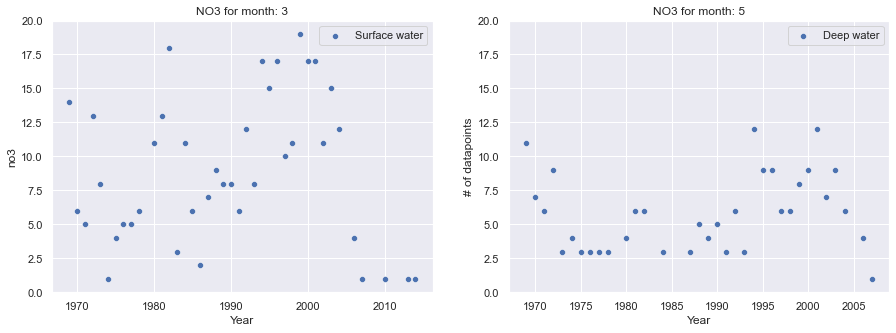

In [11]:
#COUNTING THE NUMBER OF DATAPOINTS FOR SURFACE AND DEEP WATER FOR MARCH AND MAY
"""
df_merged = df_merged[df_merged["Month"].isin(months)]

year_counts_s = df_merged[df_merged["Depth"].isin(shallow_range)].groupby(['Year']).count()
year_counts_d = df_merged[df_merged["Depth"].isin(deep_range)].groupby(['Year']).count()

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))

sns.scatterplot(data=year_counts_s, x='Year', y="no3", label='Surface water', ax=axes[0])
sns.scatterplot(data=year_counts_d, x='Year', y="no3", label='Deep water', ax=axes[1])

axes[0].set_title('NO3 for month: 3')
axes[0].set_ylim(0,20)
axes[1].set_title('NO3 for month: 5')
axes[1].set_ylim(0,20)
plt.ylabel("# of datapoints")
plt.show()
"""

In [11]:
#GETTING THE AVERAGES FOR YEAR & DEPTH

#df = df_merged[df_merged["Month"]==3][["Year","Depth","no3"]]

df3 = df_merged[df_merged["Month"]==3]
df3["Depth"] = df3["Depth"].round(0) #round all Depth to discrete numbers
df3=df3.groupby(["Year","Depth"]).mean()
df3 = df3.reset_index()

df5 = df_merged[df_merged["Month"]==5]
df5["Depth"] = df5["Depth"].round(0) #round all Depth to discrete numbers
df5=df5.groupby(["Year","Depth"]).mean()
df5 = df5.reset_index()
df5

print(df3.head())
print(df5.head())

     Year  Depth  Month        Day       no3
0  1969.0    0.0    3.0   4.500000  2.065000
1  1969.0    1.0    3.0   8.000000  2.240000
2  1969.0    2.0    3.0  28.000000  2.870000
3  1969.0    5.0    3.0  13.333333  2.483333
4  1969.0   10.0    3.0  11.250000  2.327500
     Year  Depth  Month   Day   no3
0  1966.0  100.0    5.0  11.0  3.14
1  1966.0  240.0    5.0  11.0  2.80
2  1969.0    0.0    5.0  18.0  0.14
3  1969.0   10.0    5.0  18.0  0.14
4  1969.0   20.0    5.0  18.0  0.14


PLOTLY

In [12]:
import chart_studio.plotly as py
import cufflinks as cf
import plotly.express as px
%matplotlib inline

# Make Plotly work in your Jupyter Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
# Use Plotly locally
cf.go_offline()

# Allows us to create graph objects for making more customized plots
import plotly.graph_objects as go

#for subplots
from plotly.subplots import make_subplots

In [13]:
#SCATTER plot om plotly express

fig = px.scatter(df5, x="Year", y="Depth", hover_data=["no3", "Day"], color="no3")
fig.update_layout(title="NO3 overview", xaxis_title= "year", yaxis_title="Depth", yaxis = dict(autorange="reversed"))
fig.update_traces(marker_size=8)
fig.show()

In [14]:
#HEATMAPS to compare two months

"""
Choosable parameters
"""
month1 = 3
month2 = 5
var = "sal"
station = "271"

"""
CODE
"""

df_m1 = dict_of_dfs[var][station][dict_of_dfs[var][station]["Month"]==month1]
df_m2 = dict_of_dfs[var][station][dict_of_dfs[var][station]["Month"]==month2]


fig = make_subplots(rows=2, cols=1, vertical_spacing = 0.1, subplot_titles=(month_dict[month1], month_dict[month2]))

zmax = 12
zmin = 0

fig.add_trace(go.Heatmap(z=df_m1[var], 
                         x=df_m1["Year"], 
                         y=df_m1["Depth"],
                         hoverinfo = ['z']),
              row=1, col=1)

fig.add_trace(go.Heatmap(z=df_m2[var], 
                         x=df_m2["Year"], 
                         y=df_m2["Depth"],  
                         hoverinfo = ['z']),
              row=2, col=1)

fig.update_layout(title=title_dict[var],
                  xaxis_title= "year", 
                  yaxis_title="Depth",
                  yaxis = dict(range=[100,0]),
                  height=1200, width=1000)

fig.update_yaxes(title_text="Depth[m]", range=[100, 0], row=2, col=1)
fig.update_yaxes(title_text="Depth [m]", range=[100, 0], row=1, col=1)

fig.update_traces(colorbar_len=0.6, 
                selector=dict(type='heatmap'), 
                zmax=zmax, 
                zmin=zmin, 
                zsmooth = 'best',
                colorscale="Viridis",
                colorbar={"title": units_dict[var]})

fig.show()

In [56]:
#dataframe INTERPOLATION function

def interpolate_var(df, var, kind="linear"):
    """takes in the original data frame and the variable and outputs the interpolated data frame (all months, all years)"""
    df = get_df_monthly_means(df) #getting averages for each month
    df_out =pd.DataFrame(columns=["Year","Month","Depth", var])
    for month in list(range(1,13)):
        df_m = df[df["Month"]==month]
        for year in df_m["Year"].unique().tolist():
            df_m_y = df_m[df_m["Year"]==year]
            if len(df_m_y) < 2: #cannot interpolae with 1 data point
                pass
            else:
                f = interpolate.interp1d(df_m_y["Depth"],df_m_y[var], fill_value="extrapolate", kind=kind)

                new_df = pd.DataFrame(columns=["Year","Month","Depth", var])
                new_df["Depth"]=np.arange(0,250,1) #note: first the column with known dimension, then fill up with year & month
                new_df[var]=f(np.arange(0,250,1))
                new_df["Year"]=year
                new_df["Month"]=month
                
                df_out = df_out.append(new_df)
    return df_out

interpolate_var(dict_of_dfs["sal"]["271"],"sal")
#dict_of_dfs["sal"]["271"]

Year Month Depth        sal
0    1961.0     1     0   7.207551
1    1961.0     1     1   7.248776
2    1961.0     1     2   7.290000
3    1961.0     1     3   7.331224
4    1961.0     1     4   7.372449
..      ...   ...   ...        ...
245  2004.0    12   245  12.917000
246  2004.0    12   246  12.919800
247  2004.0    12   247  12.922600
248  2004.0    12   248  12.925400
249  2004.0    12   249  12.928200

[116500 rows x 4 columns]

In [16]:
#saldf_means[(saldf_means["Year"]==1985) & (saldf_means["Month"]==3)][50:70] - some false measurements

In [57]:
#COMPARISON OF INTERPOLATED AND NON-INTERPOLATED COLUMNS

"""
Choosable parameters
"""
var = "sal" #variable of interest (no3, sal)
station = "271" #station of interest (271, 213, 113)
month = 5 #month of interest
kind = "nearest" #type of interpolation

"""
Code
"""

df = dict_of_dfs[var][station] #getting the df of interest

inter_df = interpolate_var(df, var, kind)

fig = make_subplots(rows=1, cols=2, subplot_titles=(["Raw","Interpolated"]))

fig.add_trace(
    go.Scatter(x=df[df["Month"]==month]["Year"], 
            y=df[df["Month"]==month]["Depth"], 
            marker_color=df[df["Month"]==month][var],
            hoverinfo = "text",
            hovertext = df[df["Month"]==month][var]),
            row=1, col=1
)

fig.add_trace(
    go.Scatter(x=inter_df[inter_df["Month"]==month]["Year"], 
            y=inter_df[inter_df["Month"]==month]["Depth"], 
            marker_color=inter_df[inter_df["Month"]==month][var],
            hoverinfo = "text",
            hovertext = inter_df[inter_df["Month"]==month][var]),
            row=1, col=2
)

fig.update_layout(height=600, 
                width=1200, 
                title_text="Comparison of interpolated and raw data",
                showlegend=False)

fig.update_traces(selector=dict(type='scatter'),
                mode = "markers",
                marker=dict(
                    cmax=13, 
                    cmin=0,
                    colorscale="Viridis",
                    showscale=True,
                    colorbar=dict(title=units_dict[var])))

fig.update_yaxes(range=[200, 0], row=1, col=1, title="Depth[m]")
fig.update_yaxes(range=[200, 0], row=1, col=2, title="Depth[m]")
fig.update_xaxes(range=[1960, 2020], row=1, col=1, title="Year")
fig.update_xaxes(range=[1960, 2020], row=1, col=2, title="Year")

fig.show()

In [69]:
#DETERMINE HALOCLINE

# assumes interpolated data frame with sorted depth (increasing with df index)"""

def get_halocline(df, m=30): 
    """Function that gets the dataframe for a single month and calculates a halocline for each year"""
    halocline_df = pd.DataFrame(columns=["Year", "halocline"])
    for year in df["Year"].unique().tolist():
        df_y = df[df["Year"]==year]
        depth_i = df_y.columns.get_loc("Depth")
        sal_i = df_y.columns.get_loc("sal")
        temp_max = 0
        temp_depth = None
        for row_index in range(0, len(df_y)-31):
            if df_y.iloc[row_index+30, sal_i]- df_y.iloc[row_index, sal_i] > temp_max:
                temp_depth = (df_y.iloc[row_index+30, depth_i]+df_y.iloc[row_index, depth_i])/2
                temp_max = df_y.iloc[row_index+30, sal_i]- df_y.iloc[row_index, sal_i]

        halocline_df = halocline_df.append({'Year': year, 'halocline':temp_depth}, ignore_index=True)
    return halocline_df

#get_halocline(dict_of_dfs["sal"]["271"][dict_of_dfs["sal"]["271"]["Month"]==5])
inter_sal = interpolate_var(df=dict_of_dfs["sal"]["271"], var="sal", kind="nearest")
#inter_sal[inter_sal["Month"]==5]

get_halocline(inter_sal[inter_sal["Month"]==3])
    
            


Year  halocline
0   1960.0       37.0
1   1969.0       71.0
2   1970.0       84.0
3   1971.0       61.0
4   1972.0       81.0
5   1973.0       70.0
6   1974.0       81.0
7   1975.0       81.0
8   1976.0       81.0
9   1977.0       71.0
10  1978.0       80.0
11  1980.0       79.0
12  1981.0       71.0
13  1982.0       83.0
14  1983.0      148.0
15  1984.0       76.0
16  1985.0       63.0
17  1986.0       76.0
18  1988.0       80.0
19  1989.0       76.0
20  1990.0       84.0
21  1992.0      102.0
22  1993.0       97.0
23  1994.0       83.0
24  1995.0       87.0
25  1996.0       80.0
26  1997.0       91.0
27  1998.0       80.0
28  1999.0       70.0
29  2000.0       81.0
30  2001.0       73.0
31  2002.0       71.0
32  2003.0       76.0
33  2004.0       77.0
34  2007.0       84.0
35  2008.0       80.0
36  2009.0       79.0
37  2010.0       60.0
38  2011.0       80.0
39  2012.0       78.0
40  2013.0       73.0
41  2014.0       82.0
42  2015.0       79.0
43  2016.0       79.0
44  2017.0       78.0
45  2018.0       82.0
46  2019.0       74.0